In [ ]:
!pip install nfl_data_py

First, lets import all libraries we will need, including our dataset.

In [49]:
import nfl_data_py as nfl
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.stats import pearsonr, ttest_rel, f_oneway, tukey_hsd

Hypothesis #1:
Null Hypothesis: The season of a game played does not effect the proportion of pass plays (as opposed to run plays) called in that game.
Alternative Hypothesis: The season of a game played effects the proportion of pass plays (as opposed to run plays) called in that game.

We will use an alpha of 0.05

First, we will cache the play by play data to speed up data access.

In [30]:
nfl.cache_pbp([2000, 2005, 2010, 2015])


2000 done.
2005 done.
2010 done.
2015 done.


Now, lets look at what type of data we have available for our use in this dataset.

In [ ]:
idx = nfl.see_pbp_cols()
for col in idx:
  print(col)

play_id
game_id
old_game_id
home_team
away_team
season_type
week
posteam
posteam_type
defteam
side_of_field
yardline_100
game_date
quarter_seconds_remaining
half_seconds_remaining
game_seconds_remaining
game_half
quarter_end
drive
sp
qtr
down
goal_to_go
time
yrdln
ydstogo
ydsnet
desc
play_type
yards_gained
shotgun
no_huddle
qb_dropback
qb_kneel
qb_spike
qb_scramble
pass_length
pass_location
air_yards
yards_after_catch
run_location
run_gap
field_goal_result
kick_distance
extra_point_result
two_point_conv_result
home_timeouts_remaining
away_timeouts_remaining
timeout
timeout_team
td_team
td_player_name
td_player_id
posteam_timeouts_remaining
defteam_timeouts_remaining
total_home_score
total_away_score
posteam_score
defteam_score
score_differential
posteam_score_post
defteam_score_post
score_differential_post
no_score_prob
opp_fg_prob
opp_safety_prob
opp_td_prob
fg_prob
safety_prob
td_prob
extra_point_prob
two_point_conversion_prob
ep
epa
total_home_epa
total_away_epa
total_home_rush_epa


We notice that there is a "play_type" column. This will be useful to determine if a play is a rushing or a passing attempt. Let's load this data into a data frame and see what types of values we can have for this column.

In [31]:
df = nfl.import_pbp_data([2000,2005,2010, 2015], columns=["play_type", "season", "week"])
df.value_counts(["play_type"])

2000 done.
2005 done.
2010 done.
2015 done.
Downcasting floats.


,0
play_type,
pass,75858
run,56392
no_play,15998
kickoff,10335
punt,10316
extra_point,4777
field_goal,3973
qb_kneel,1223
qb_spike,210


The end goal is to determine if pass plays are being called more frequently than run plays. Therefore, we will drop all entries where the play types is neither a pass or a run.

In [ ]:
df = df[(df["play_type"] == "pass") | (df["play_type"] == "run")]
df.value_counts(["play_type"])

,0
play_type,
pass,38852
run,27296


Next, we will separate the data frame into four separate data frames based on the season of the game played. We will also calculate the proportion of pass plays called for each game.

In [36]:
df["isPass"] = df["play_type"].apply(lambda x: 1 if x == "pass" else 0)
df_2000 = df[df["season"] == 2000]
df_2005 = df[df["season"] == 2005]
df_2010 = df[df["season"] == 2010]
df_2015 = df[df["season"] == 2015]
df_2000 = df_2000.groupby("old_game_id")[["isPass", "week"]].mean()
df_2000["week"] = df_2000["week"].astype(int)
df_2005 = df_2005.groupby("old_game_id")[["isPass", "week"]].mean()
df_2005["week"] = df_2005["week"].astype(int)
df_2010 = df_2010.groupby("old_game_id")[["isPass", "week"]].mean()
df_2010["week"] = df_2010["week"].astype(int)
df_2015 = df_2015.groupby("old_game_id")[["isPass", "week"]].mean()
df_2015["week"] = df_2015["week"].astype(int)
print("2000:")
print(df_2000["isPass"].describe())
print("2005:")
print(df_2005["isPass"].describe())
print("2010:")
print(df_2010["isPass"].describe())
print("2015:")
print(df_2015["isPass"].describe())

2000:
count    257.000000
mean       0.394314
std        0.046390
min        0.274419
25%        0.364162
50%        0.396907
75%        0.425287
max        0.497409
Name: isPass, dtype: float64
2005:
count    267.000000
mean       0.390891
std        0.044780
min        0.162651
25%        0.362866
50%        0.395349
75%        0.420754
max        0.515625
Name: isPass, dtype: float64
2010:
count    267.000000
mean       0.407730
std        0.045588
min        0.239130
25%        0.379079
50%        0.405882
75%        0.437791
max        0.540107
Name: isPass, dtype: float64
2015:
count    267.000000
mean       0.422461
std        0.043245
min        0.303483
25%        0.395279
50%        0.424581
75%        0.452119
max        0.532609
Name: isPass, dtype: float64


Since we are comparing the means of four different samples, we will use the anova test to see if we should reject our null hypothesis or not. We will use an alpha of 0.05.

In [37]:
anova = f_oneway(df_2000["isPass"], df_2005["isPass"],df_2010["isPass"], df_2015["isPass"])
anova.pvalue

6.852508676561381e-17

Since our pvalue is much less than our alpha of 0.05, we choose to reject our null hypothesis. This means that the average proportion of pass plays called per game is effected by the season of which the game is played in.

Lets plot this data to observe our differences.

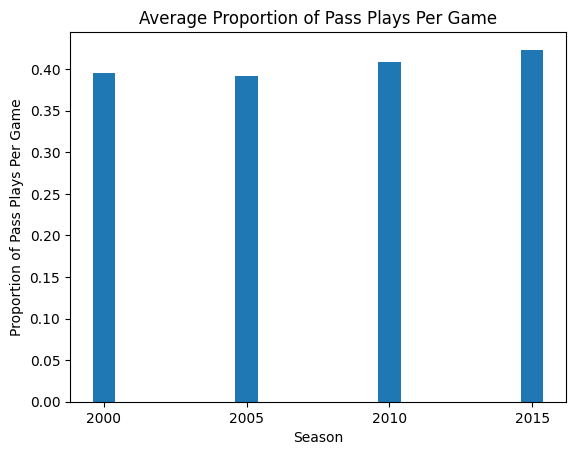

In [47]:
df["season"] = pd.Categorical(df["season"], [2000,2005,2010,2015])
means = df.groupby('season',observed=False)['isPass'].mean()
plt.bar(means.index, means.values)
plt.xticks([2000,2005,2010,2015])
plt.title("Average Proportion of Pass Plays Per Game")
plt.xlabel("Season")
plt.ylabel("Proportion of Pass Plays Per Game")
plt.show()

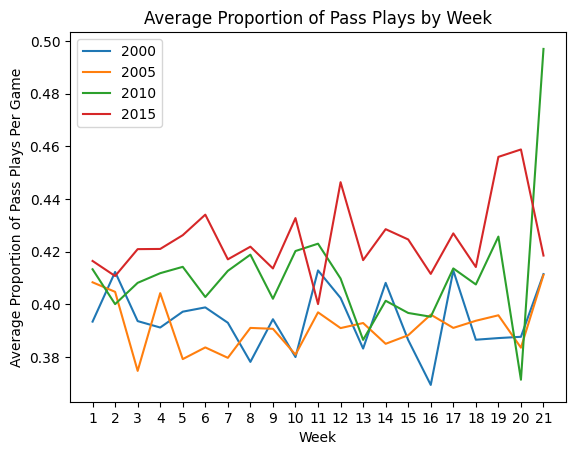

In [48]:
per_week_2000 = df_2000.groupby("week").mean()
per_week_2005 = df_2005.groupby("week").mean()
per_week_2010 = df_2010.groupby("week").mean()
per_week_2015 = df_2015.groupby("week").mean()
plt.plot(per_week_2000, label ='2000')
plt.plot(per_week_2005, label ='2005')
plt.plot(per_week_2010, label ='2010')
plt.plot(per_week_2015, label = '2015')
plt.title("Average Proportion of Pass Plays by Week")
plt.xticks(range(1,22))
plt.xlabel("Week")
plt.ylabel("Average Proportion of Pass Plays Per Game")
plt.legend()
plt.show()

As we can see by the plots, the average proportion of pass plays called per game differs depending on the season. This is consistent with our conclusion from our hypothesis test. There seems to be an upward trend in the proportion of pass plays called as the years progress.

Since we decided to reject our null hypothesis, let's run a post-hoc test to better understand which seasons may be causing this difference. We will use Tukey's HSD test for this.


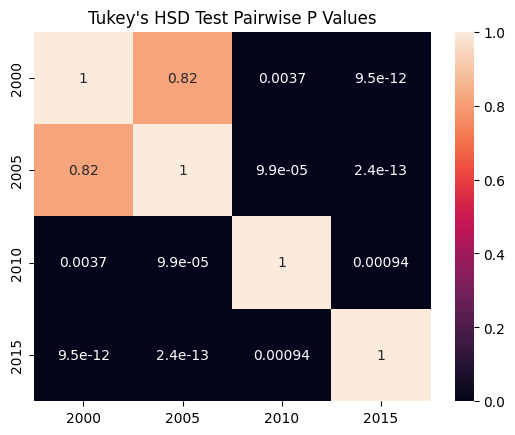

In [62]:
tukey = tukey_hsd(df_2000["isPass"], df_2005["isPass"],df_2010["isPass"], df_2015["isPass"])
pvals = list(tukey.pvalue)
plt.figure()
sns.heatmap(pvals, annot=True,xticklabels=[2000,2005,2010,2015], yticklabels=[2000,2005,2010,2015])
plt.title("Tukey's HSD Test Pairwise P Values")
plt.show()

Looking at the array of p-values from Tukey's HSD test, the only pair of seasons that did not have a significant difference in the proportion of pass plays called per game is 2000 and 2005, with a pairwise p value of 0.82.

Hypothesis #2

Null Hypothesis: There is no linear correlation between the number of passing attempts and the number of interceptions.
Alternative Hypothesis: There is a linear correlation between the number of passing attempts and the number of interceptions.

In [ ]:
data = nfl.import_seasonal_data(list(range(2000, 2025)))
data = pd.DataFrame(data)
data.dropna(subset=['attempts', 'interceptions'], inplace=True)
data = data[data['attempts'] > 0]

We decide to test our hypothesis over the years 2000 to 2024. To clean our data, we drop any rows with NaN values in the 'attempts' and 'interception' columns and also make sure that our dataset only includes players who have attempted at least one pass to avoid skewed data.

In [ ]:
corr, p_value = pearsonr(data['attempts'], data['interceptions'])
print(f"Pearson Correlation Coefficient: {corr}")
print(f"P-value: {p_value}")

Pearson Correlation Coefficient: 0.893670546323543
P-value: 0.0


Since we are looking at a linear relationship over two continous variables, we decide to use a pearson correlation test. As such, we calculate the pearson correlation coefficient as well as the p-value with an alpha of 0.05. Since the correlation coefficent comes out to about 0.89 we estimate that there is a strong positive linear correlation between passing attempts and the number of interceptions over a season. Additionally, since the p-value < our alpha of 0.05 we reject the null hypothesis.

In [ ]:
filtered_data = data[data['season'].isin([2000, 2005, 2010, 2015, 2020])]

We filtered the data to include only specific seasons (2000, 2005, 2010, 2015, 2020) to provide a clearer and more focused comparison of the relationship between attempts and interceptions over time. This allows us to see whether the pattern holds consistently across key seasons without overwhelming the plot with too much data from every year. We use a linear regression plot with a regression line as it gives a visual representation of the correlation and is especially useful for detecting patterns. The regression line helps reinforce the strength of the correlation observed in the Pearson test.

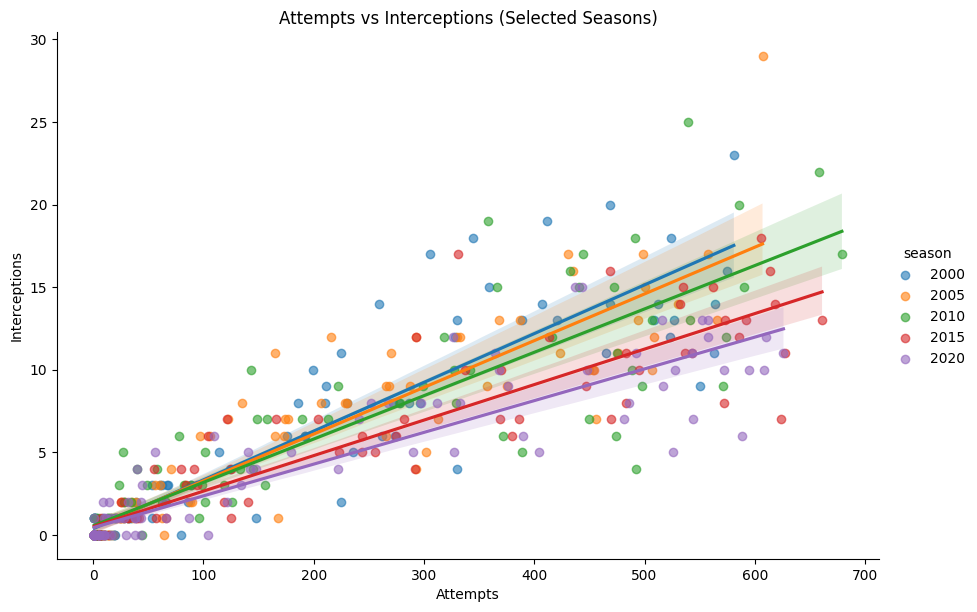

In [ ]:
sns.lmplot(x='attempts', y='interceptions', hue='season', data=filtered_data,
           height=6, aspect=1.5, scatter_kws={'alpha':0.6})

plt.title("Attempts vs Interceptions (Selected Seasons)")
plt.xlabel("Attempts")
plt.ylabel("Interceptions")

plt.show()

As we can see, there is a strong positive correlation between passing attempts and interceptions over our selected years. This is consistent with our conclusions from the hypothesis test and the pearson correlation test.

Hypothesis #3

H0: There is no difference between the number of points scored by home and away team

H1: There is a difference between the number of points scored by the home team and the away team

In [ ]:
nfl_pbp_data = nfl.import_pbp_data(years=list(range(1999, 2024)), downcast=False)
#downcast is set to False here is because while it does save us 30% or so memory,
#it causes run time speed to be about 50% slower

1999 done.
2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.


In [ ]:
nfl_pbp_data['game_date'] = pd.to_datetime(nfl_pbp_data['game_date'])
HomeVsAway = nfl_pbp_data[['game_id', 'posteam', 'home_team', 'away_team', 'posteam_score', 'defteam_score']]

#We are focused on the goals here so we would like to drop any that is NA
HomeVsAway = HomeVsAway.dropna(subset=['posteam_score', 'defteam_score'])

In [ ]:
# Determine if the possession team is the home team
HomeVsAway['is_home'] = HomeVsAway['posteam'] == HomeVsAway['home_team']

#separating home and away scores
#also the ~ is a megation operator in pandas
homeScores = HomeVsAway[HomeVsAway['is_home']].groupby('game_id')['posteam_score'].max()
awayScores = HomeVsAway[~HomeVsAway['is_home']].groupby('game_id')['posteam_score'].max()
scores_df = pd.DataFrame({'home_score': homeScores, 'away_score': awayScores}).dropna()

scores_df.head(20)

,home_score,away_score
game_id,,
1999_01_ARI_PHI,24.0,22.0
1999_01_BUF_IND,31.0,14.0
1999_01_CAR_NO,19.0,10.0
1999_01_CIN_TEN,33.0,35.0
1999_01_DAL_WAS,35.0,35.0
1999_01_DET_SEA,20.0,28.0
1999_01_KC_CHI,20.0,17.0
1999_01_MIA_DEN,20.0,38.0
1999_01_MIN_ATL,14.0,17.0


In [ ]:
scores_df.describe()

,home_score,away_score
count,6703.000000,6703.000000
mean,22.980755,20.528718
std,10.348425,9.996510
min,0.000000,0.000000
25%,16.000000,13.000000
50%,23.000000,20.000000
75%,30.000000,27.000000
max,70.000000,59.000000


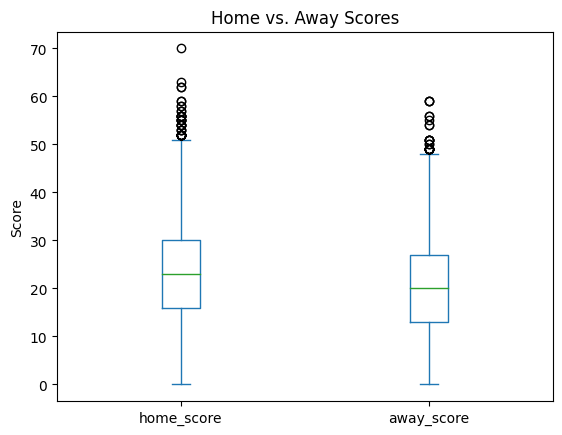

In [ ]:
scores_df.plot(kind='box' , title='Home vs. Away Scores')
plt.ylabel('Score')
plt.show()
#We can see below that home score has way more outliers and that the median is higher as well


In [ ]:
Tstat, Pvalue = ttest_rel(scores_df['home_score'], scores_df['away_score'])

Pvalue

3.468119939554915e-42

Since the P value is much less then .05, we can safely reject the null hypothesis and say that there is definitely a home team advantage in terms of points scored.